# Imports

In [53]:
from skimage import io
import skimage
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, uniform_filter
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import imageio
from pathlib import Path
from matplotlib.pyplot import show
from argparse import ArgumentParser

from pyoptflow.plots import compareGraphs

In [55]:
from PIL import Image
import os
from scipy.signal import argrelextrema
from skimage import exposure

In [56]:
import matplotlib
import matplotlib.animation
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [57]:
epsilon = 1/1000

### Import our custom utility methods

In [58]:
import sys
%reload_ext autoreload
%autoreload 2
sys.path.append('..')

from utils.visualization_tools import *
import utils.visualization_tools
from utils.data_transformations import *
import utils.data_transformations
from utils.diverse import *
import utils.diverse

The following modules are available

In [7]:
print_module_methods(utils.diverse)

NestedDict()

print_module_methods(module)

set_random_state(seed_value=42)

slow_wave_features(dataset, features, where=None)



In [8]:
print_module_methods(utils.visualization_tools)

HTML(data=None, url=None, filename=None, metadata=None)

display_combined(u, v, Inew, scale=100, quivstep=3, fig=None, ax=None, figsize=(10, 10), vmin=0, vmax=1, head_width=1, mode='minimal')

fig2rgb_array(fig)

manifold(decoder, x_range=[-2, 2], y_range=[-0.5, -2.5], n=10, figsize=(8, 8), dpi=100, n_interp=100, scale='sqrt')

plot_animation(vectors, i_min=0, n_frames=10, norm=True)

plot_vector_as_field(y, x, scale=1)

print_points_and_background(img, x, y, point_size=10, marker='.')

render_arrow_components(up=1, down=1, left=1, right=1, cmap='Blues')

show_video(frames, frames1=None, n_frames=20, startframe=0, orient='horizontal', figsize=(10, 10), vmin=0, vmax=1, cmap='viridis', show_framenumber=True, jshtml=True)

stretch(vector, n_interp, norm=True)

superimpose(img, background, cm_background=<matplotlib.colors.LinearSegmentedColormap object at 0x7f1e51dca190>, cm_foreground=<matplotlib.colors.ListedColormap object at 0x7f1e51de2490>)

vector_field_animation(y_comp, x_comp, tens

In [9]:
print_module_methods(utils.data_transformations)

HornSchunck(im1: numpy.ndarray, im2: numpy.ndarray, alpha: float = 0.001, Niter: int = 8, verbose: bool = False) -> Tuple[numpy.ndarray, numpy.ndarray]

PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)

apply_mask(frames, mask, nan=False)

argrelextrema(data, comparator, axis=0, order=1, mode='clip')

binary_dilation(input, structure=None, iterations=1, mask=None, output=None, border_value=0, origin=0, brute_force=False)

binary_erosion(input, structure=None, iterations=1, mask=None, output=None, border_value=0, origin=0, brute_force=False)

butter(N, Wn, btype='low', analog=False, output='ba', fs=None)

butter_bandstop_filter(data, lowcut, highcut, fs, order)

center_of_mass(a)

clipped_adaptive(tensor, clipping=0.8)

dilate_median(tensor, mask, iterations=10)

discard_minor_components(tensor, keep_components=3, n_components=None, pca=None, fit_only=False)

equalize_adapthist(image, kernel_size=None, clip_limit=0.

In [10]:
mask = np.array(Image.open("mask_150_150.png"))[:,:,0] == 255

In [11]:
#plt.imshow(mask)

# Simulation of global flow

In [12]:
from skimage.util.shape import view_as_windows
def dilate_median(tensor, mask, iterations = 10):
    """ Masks tensor and for each frame it dilates the median of the outline iteratively.
        The remaining background pixels are zero in the output tensor (and not np.nan).
    """
    tensor = apply_mask(tensor, mask, nan=True)
    def get_outline(foreground_mask):
        outline = ~(binary_dilation(foreground_mask)^~foreground_mask)
        return outline
    def dilate_median_frame(frame, mask, n_iterations, inline=False):
        if not inline:
            frame = frame.copy()
        mask = mask.copy()
        for i in range(n_iterations):
            outline = get_outline(~mask)
            frame[outline] = np.nanmedian(np.pad(view_as_windows(frame,(3,3)),((1,1),(1,1),(0,0),(0,0)))[outline],axis=(1,2))
            mask[outline] = False 
        return frame
    
    mask = np.isnan(tensor[0])
    for i, x in enumerate(tensor):
        tensor[i] = dilate_median_frame(x, mask, iterations)
    tensor[np.isnan(tensor)] = 0
    return tensor

In [13]:
def add_increasing_brightness_gradient(tensor,n_columns=150,time_factor=10):
    """ Adds gradient (from bright top to dark bottom) to tensor with increasing brightness over time"""
    for x in range(tensor.shape[0]):
        a = np.array(np.arange(n_columns))
        a = np.flipud(np.tile(a,(n_columns,1)).T)
        tensor[x] = a * (time_factor*x+1)
    return tensor

In [14]:
n_columns = 150
tensor_global_flow = np.zeros((50,n_columns,n_columns))

In [15]:
tensor_global_flow = add_increasing_brightness_gradient(tensor_global_flow)
tensor_global_flow = normalize(tensor_global_flow,100)

In [16]:
tensor_global_flow = dilate_median(tensor_global_flow, 20)

In [17]:
x_comp_global, y_comp_global = horn_schunck(tensor_global_flow)

.

In [18]:
#Apply mask
tensor_global_flow = apply_mask(tensor_global_flow, mask, nan=True)
x_comp_global, y_comp_global = [apply_mask(x_comp_global,mask, nan=True), apply_mask(y_comp_global,mask, nan=True)]

In [38]:
%%capture
ani = vector_field_animation(y_comp_global, x_comp_global, tensor_global_flow, scale= 1000, quivstep=15)

.........................................

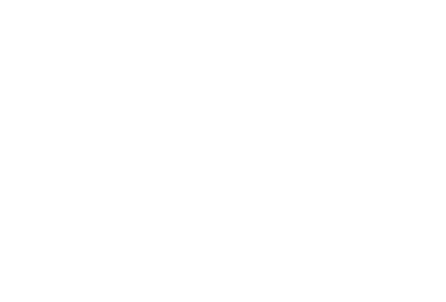

In [35]:
from IPython.display import HTML
HTML(ani.to_jshtml())

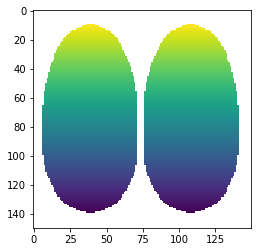

In [74]:
plt.imshow(tensor_global_flow[i])

In [523]:
def add_subplots_vfields(ax, y_comp,x_comp, tensor_flow, quivstep = 15, fontsize = 8):
	vmin = np.nanmin(tensor_flow[5])
	vmax = np.nanmax(tensor_flow[10])
	scale = 3000
	width = .3

	i = 0
	display_combined(y_comp[i], x_comp[i], tensor_flow[i], quivstep = quivstep, fig = fig, ax=ax[0], 
		         scale = scale, head_width = 5, head_length = 2, vmin = vmin, vmax = vmax, width = width)
	ax[0].set_xticks([])
	ax[0].set_yticks([])
	ax[0].set_xlabel("frame = 0", fontsize = fontsize)


	i = 5
	display_combined(y_comp[i], x_comp[i], tensor_flow[i], quivstep = quivstep, fig = fig, ax=ax[1], 
		         scale = scale, head_width = 5, head_length = 2, vmin = vmin, vmax = vmax, width = width)
	ax[1].set_xticks([])
	ax[1].set_yticks([])
	ax[1].set_xlabel("frame = 5", fontsize = fontsize)

	i = 10

	display_combined(y_comp[i], x_comp[i], tensor_flow[i], quivstep = quivstep, fig = fig, ax=ax[2], 
		         scale = scale, head_width = 5, head_length = 2, vmin = vmin, vmax = vmax, width = width)
	plt.axis("on")
	ax[2].set_xticks([])
	ax[2].set_yticks([])
	ax[2].set_xlabel("frame = 10", fontsize = fontsize)

#### Simulation of local flow

In [209]:
tensor_global_flow.shape

(50, 150, 150)

In [302]:
tensor_local_flow = np.empty_like(tensor_global_flow)
tensor_local_flow.fill(0)
tensor_local_flow[20:50, 100:110, 35:45] = .5
tensor_local_flow[20:50, 100:110, 110:120] = .5
tensor_local_flow = gaussian_filter(tensor_local_flow, 10)
tensor_local_flow = normalize(tensor_local_flow)/2

In [303]:
tensor_local_flow = dilate_median(tensor_local_flow, 10)
x_comp_local, y_comp_local = horn_schunck(tensor_local_flow)

.

In [304]:
tensor_local_flow = apply_mask(tensor_local_flow, mask, nan=True)
x_comp_local, y_comp_local = [apply_mask(x_comp_local,mask, nan=True), apply_mask(y_comp_local,mask, nan=True)]

In [305]:
%%capture
ani = vector_field_animation(y_comp_local, x_comp_local, tensor_local_flow, scale= 1000, quivstep=10)

.........................................

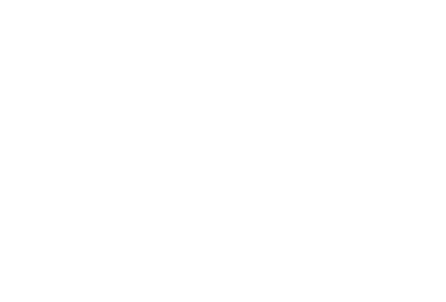

In [306]:
from IPython.display import HTML
HTML(ani.to_jshtml())

# A convoluted signal of global and local flow

In [292]:
convoluted = (tensor_local_flow + tensor_global_flow)/2

In [293]:
convoluted = gaussian_filter_nan(convoluted, 2)

../utils/data_transformations.py:171: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


In [294]:
%%capture
ani = show_video(convoluted, n_frames = len(convoluted))

In [295]:
HTML(ani)

In [296]:
convoluted = dilate_median(convoluted, 10)

In [297]:
x_comp_convoluted, y_comp_convoluted = horn_schunck(convoluted)
convoluted = apply_mask(convoluted, mask, nan=True)
x_comp_convoluted, y_comp_convoluted = [apply_mask(x_comp_convoluted,mask, nan=True), apply_mask(y_comp_convoluted,mask, nan=True)]

.

In [298]:
%%capture
ani = vector_field_animation(y_comp_convoluted, x_comp_convoluted, convoluted, scale= 1000, quivstep=10)

.........................................

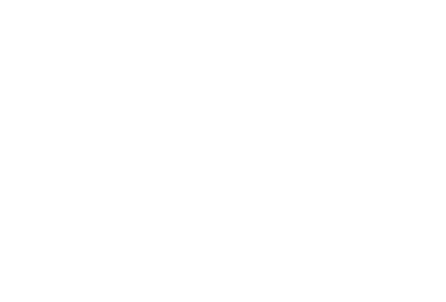

In [299]:
HTML(ani.to_jshtml())

# Helmhotz Decomposition

In [456]:
from pynhhd import nHHD

def natural_helmholtz_decompositon(vfield):
    """ Computes the natural Helmholtz decomposition for a single 2D vector field
    Args:
        vfield: A vector field of shape [2, width, height] where the y component comes first. 
        This could either be a numpy array or a list [y_component, x_component] where both y_component and x_component refer to 2d numpy arrays.
    Returns:
        solenoidal: Solenoidal vector field (divergence free)
        curl_free: Curl free vector field (divergent field)
        harmonic: Harmonic component vector field
        solenoidal_potential: 2d numpy array
        curl_free_potential: 2d numpy array
        divergence: Divergence of the original vector field. 2d numpy array.
    """
    vfield = [vfield[1], vfield[0]]
    vfield = np.einsum("ijk->kij", vfield)
    vfield = np.einsum("ijk->kij", vfield)
    
    if np.any(np.isnan(vfield)):
        vfield[np.isnan(vfield)] = 0
    
    dims = (vfield.shape[0],vfield.shape[1])
    nhhd = nHHD(grid=dims, spacings=(0.1,0.1))
    nhhd.decompose(vfield)
    
    solenoidal = np.array([nhhd.r[:,:,1], nhhd.r[:,:,0]])
    curl_free = np.array([nhhd.d[:,:,1], nhhd.d[:,:,0]])
    harmonic = np.array([nhhd.h[:,:,1], nhhd.h[:,:,0]])
    solenoidal_potential = nhhd.nRu
    curl_free_potential = nhhd.nD
    divergence = nhhd.div
    return solenoidal, curl_free, harmonic, solenoidal_potential, curl_free_potential, divergence

def helmholtz_decomposition(vfields, mask = None, approach = "nhhd"):
    """ Computes the helmholtz_decomposition using the specified approach
    args:
        v_fields: Tensor of vector fields of shape [2, n_frames, height, width] or a single vectorfield of shape [2, height, width].
        mask: Mask to be applied on the decompositions
        approach: Approach to compute helmholtz_decomposition. By now only natural helmholtz decomposition is supported.
    returns:
        solenoidal_gradient: Vector field representation of divergence free (solenoidal) component
        solenoidal_function: 2d scalar potential representation of solenoidal_function.
        curl_free_gradient: Vector field representation of curl free component
        curl_free_function: 2d scalar function representation of curl free component. The gradient of this component is the vector field representation (solenoidal_gradient).
    """
    if approach != "nhhd":
        raise NotImplementedException("Only natural helmholtz decomposition is supported by now")

    if vfields.ndim == 3:#Insert empty dimension
        vfields = np.array([[vfields[0]],[vfields[1]]])
        
    if np.any(np.isnan(vfields[0])):
        print("Replacing nan with zero")
        vfields[np.isnan(vfields)] = 0

    solenoidal = np.zeros(shape=vfields.shape, dtype=np.float32)
    curl_free = np.zeros(shape=vfields.shape, dtype=np.float32)
    curl_free_potential = np.zeros(shape=vfields[0].shape, dtype=np.float32)
    solenoidal_potential = np.zeros(shape=vfields[0].shape, dtype=np.float32)

    for i in range(vfields.shape[1]):
        if i % 10 == 0:
            print(".", end="")
        vfield = vfields[:,i,:,:].copy()
        solenoidal[:,i,:,:], curl_free[:,i,:,:], _, solenoidal_potential[i,:,:], curl_free_potential[i,:,:], _ = natural_helmholtz_decompositon(vfield)
        if type(mask) != type(None):
            solenoidal[0,i][:,:][mask] = np.nan
            solenoidal[1,i][:,:][mask] = np.nan
            curl_free[0,i][:,:][mask] = np.nan
            curl_free[1,i][:,:][mask] = np.nan
            curl_free_potential[i][:,:][mask] = np.nan
            solenoidal_potential[i][:,:][mask] = np.nan
            
    return solenoidal, solenoidal_potential, curl_free, curl_free_potential

In [593]:
def plot_solenoidal_and_curl_free(vfield, mask, scale= .5, fig=None, ax=None):


    vfield[np.isnan(vfield)] = 0
    solenoidal, curl_free, harmonic, solenoidal_potential, curl_free_potential, div = natural_helmholtz_decompositon(vfield)
    
    vfield[0] = apply_mask([vfield[0]], mask, nan=True)[0]
    vfield[1] = apply_mask([vfield[1]], mask, nan=True)[0]
    curl_free[0] = apply_mask([curl_free[0]], mask, nan=True)[0]
    curl_free[1] = apply_mask([curl_free[1]], mask, nan=True)[0]
    solenoidal[0] = apply_mask([solenoidal[0]], mask, nan=True)[0]
    solenoidal[1] = apply_mask([solenoidal[1]], mask, nan=True)[0]
    
    solenoidal_potential = apply_mask([solenoidal_potential], mask)[0]
    curl_free_potential = apply_mask([curl_free_potential], mask)[0]    
    
    width = .3
    vmax = np.max([np.abs(np.min(curl_free_potential)),np.max(curl_free_potential)])
    
    
    display_combined(vfield[0], vfield[1], np.sqrt(vfield[1]**2+vfield[0]**2), scale=scale/2, fig=fig, ax = ax[0],
                             head_width = 5, head_length = 2, width = width, quivstep = 8)
    display_combined(curl_free[0],curl_free[1], curl_free_potential, scale=scale/2, fig=fig, ax=ax[1],
                    head_width = 5, head_length = 2, width = width, quivstep = 8, cmap ="coolwarm", vmin = -vmax, vmax = vmax)

    vmax = np.nanmax([np.abs(np.nanmin(solenoidal_potential)),np.nanmax(solenoidal_potential)])

    display_combined(solenoidal[0],solenoidal[1], solenoidal_potential, scale=scale, fig=fig, ax=ax[2],
                    head_width = 5, head_length = 2, width = width, quivstep = 8, cmap ="BrBG", vmin = -vmax, vmax = vmax)
    plt.axis("on")

    
    ax[0].set_title(" Optical flow", fontsize=8)
    ax[1].set_title("Sources and sinks", fontsize=8)
    ax[2].set_title("Flow", fontsize=8)
    
    for i, a in enumerate(ax):
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.text(-0.03, 1.03, string.ascii_uppercase[i], transform = a.transAxes, size= 12, weight = "bold")


    plt.tight_layout()
    plt.show()



    plt.tight_layout()
    plt.show()
    return fig, ax

In [589]:
frame = 42
vfield = np.array([y_comp_convoluted[frame], x_comp_convoluted[frame]])*5

Text(-0.15, 1.0, 'C')

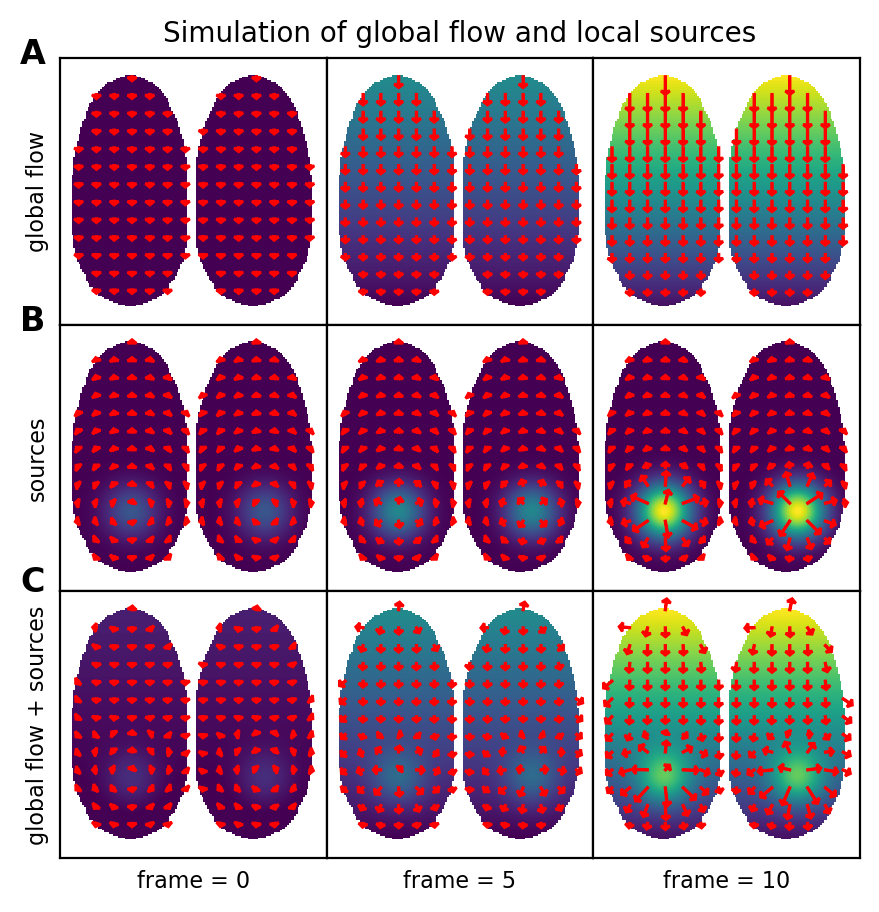

In [607]:
fig, ax = plt.subplots(3,3, figsize=(4,4), dpi = 200)
#plt.subplots_adjust(0,0,1,1,.2,.2)
add_subplots_vfields(ax[0],y_comp_global, x_comp_global, tensor_global_flow, quivstep = 10)
add_subplots_vfields(ax[1],y_comp_local, x_comp_local, tensor_local_flow, quivstep = 10)
add_subplots_vfields(ax[2],y_comp_convoluted*2, x_comp_convoluted*2, convoluted, quivstep = 10)

fontsize = 10
fontsize1 =8
ax[0,1].set_title("Simulation of global flow and local sources", fontsize= fontsize)
ax[0,0].set_ylabel("global flow", fontsize= fontsize1)
ax[1,0].set_ylabel("sources", fontsize= fontsize1)
ax[2,0].set_ylabel("global flow + sources", fontsize= fontsize1)

ax[0,0].text(-0.15, .98, "A", transform = ax[0,0].transAxes, size= 12, weight = "bold")
ax[1,0].text(-0.15, .98, "B", transform = ax[1,0].transAxes, size= 12, weight = "bold")
ax[2,0].text(-0.15, 1.0, "C", transform = ax[2,0].transAxes, size= 12, weight = "bold")

/home/ibmi/gerstenberger/anaconda3/envs/condaenv/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


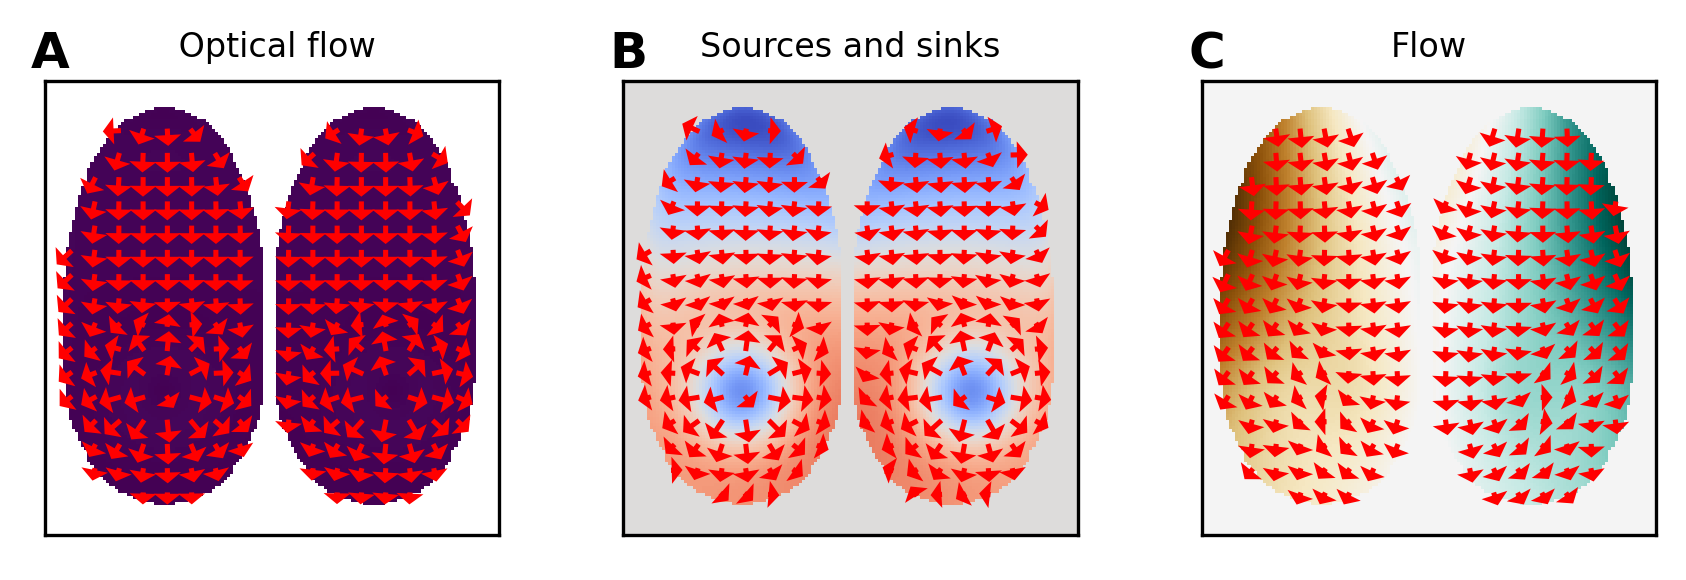

<Figure size 432x288 with 0 Axes>

In [616]:
fig = plt.figure(figsize=(8,8), dpi = 300)
ax = []

gs = fig.add_gridspec(4, 3, wspace=0.25, hspace=0.25, top=0.95, bottom=0.05, left=0.17, right=0.845) 


ax.append(fig.add_subplot(gs[3, 0]))
ax.append(fig.add_subplot(gs[3, 1]))
ax.append(fig.add_subplot(gs[3, 2]))

fig, ax = plot_solenoidal_and_curl_free(vfield, mask, scale= 500, fig = fig, ax = ax)

In [623]:
solenoidal, curl_free, harmonic, solenoidal_potential, curl_free_potential, divergence = natural_helmholtz_decompositon(vfield)
sources_sinks = curl_free_potential.copy()

Text(0.5, 1.0, 'Solenoidal (divergence free)')

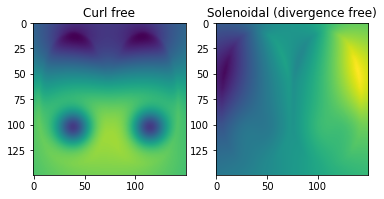

In [624]:
curl_free_potential, solenoidal_potential = normalize([curl_free_potential, solenoidal_potential])
fig, ax = plt.subplots(1,2)
ax[0].imshow(curl_free_potential, vmin = 0, vmax=1)
ax[1].imshow(solenoidal_potential, vmin=0, vmax=1)
ax[0].set_title("Curl free")
ax[1].set_title("Solenoidal (divergence free)")

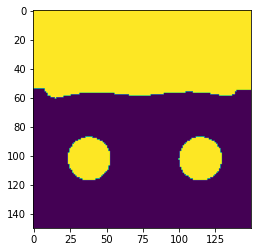

In [619]:
fig, ax = plt.subplots(1)
sources = sources_sinks < 0
ax.imshow(sources)

In [625]:
recombined = solenoidal + curl_free

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1d98bb2950>)

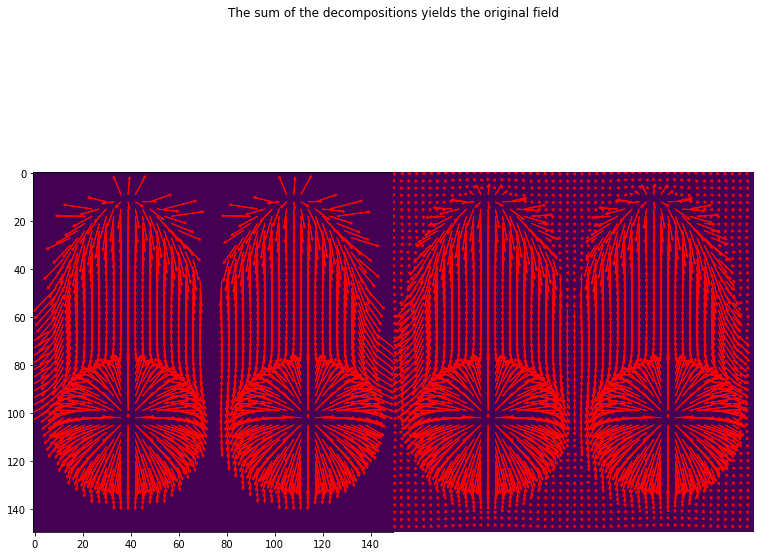

In [627]:
fig, axis = plt.subplots(1,2, figsize=(10,10))
fig.tight_layout(rect=[0, 0.2, 1, 1.2])
fig.suptitle("The sum of the decompositions yields the original field")
display_combined(vfield[0],vfield[1], np.zeros(vfield[0].shape), fig=fig, ax=axis[0], scale=1000)
display_combined(recombined[0],recombined[1], np.zeros(vfield[0].shape), fig=fig, ax=axis[1], scale= 1000)

In [628]:
curl_free_potential.shape

(150, 150)

In [637]:
def animate_helmholtz(y_comp, x_comp, start = 32, frames=10):
    fig, ax = plt.subplots(1,3)
    fig, ax = plot_solenoidal_and_curl_free(vfield, mask, scale= 2500, fig = fig, ax=ax)
    def animate(i, start, y_comp, x_comp, fig, ax):
        vfield = np.array([y_comp[i+start], x_comp[i+start]])
        _, _, plot_solenoidal_and_curl_free(vfield, mask, scale= 2500, fig=fig, ax=ax)

    ani = matplotlib.animation.FuncAnimation(fig, lambda i: animate(i, start, y_comp, x_comp, fig, ax),frames=frames)
    return ani

In [638]:
%%capture
ani = animate_helmholtz(y_comp_convoluted, x_comp_convoluted)
ani = ani.to_jshtml()

In [640]:
HTML(ani)

In [641]:
solenoidal, solenoidal_potential, curl_free, curl_free_potential = helmholtz_decomposition(np.array([y_comp_convoluted.copy(), 
                                                                                                     x_comp_convoluted.copy()]), mask=mask)

Replacing nan with zero
.....

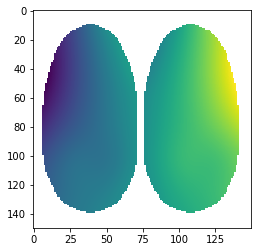

In [642]:
plt.imshow(solenoidal_potential[40])

In [643]:
def mean_vector(vfield):
    mean_vector = np.array([np.nanmean(vfield[0], axis=(1,2)), np.nanmean(vfield[1],axis=(1,2))])
    return mean_vector

In [644]:
def plot_arrows(u, v, scale=10):
    n = len(u)
    x = np.arange(-n//2,(n//2),1)
    X, Y = np.meshgrid(x, [1])

    fig, ax = plt.subplots(figsize=(10,2))
    ax.quiver(X,Y,v*scale,-u*scale)

    ax.set_aspect('auto')
    plt.show()

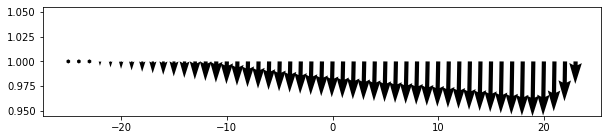

In [645]:
plot_arrows(*mean_vector([y_comp_convoluted, x_comp_convoluted]), scale=1000)

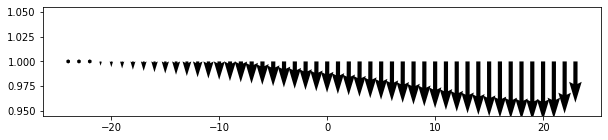

In [70]:
plot_arrows(*mean_vector(curl_free[:,:-1]), scale=1000)

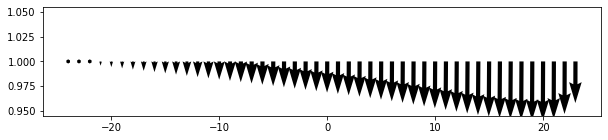

In [71]:
plot_arrows(*mean_vector(solenoidal[:,:-1]), scale=1000)

## The global flow is expected to be correlated with the solenoidal component

In [84]:
import numpy as np
import numpy.ma as ma


print(ma.corrcoef(ma.masked_invalid(x_comp_global.flatten()),
                  ma.masked_invalid(solenoidal[1].flatten()))[0,1])

-0.11311746678089327


In [85]:
print(ma.corrcoef(ma.masked_invalid(y_comp_global.flatten()),
                  ma.masked_invalid(solenoidal[0].flatten()))[0,1])

0.8573767200060566


--> For the y component the expected relationship holds. The X component has little variance (only downwards flow was simulated) and hence no meaningful correlation exists.

## The local signal is expected to be correlated with the curl free component

In [86]:
print(ma.corrcoef(ma.masked_invalid(y_comp_local.flatten()),
                  ma.masked_invalid(curl_free[0].flatten()))[0,1])

0.6592805199980504


In [87]:
print(ma.corrcoef(ma.masked_invalid(x_comp_local.flatten()),
                  ma.masked_invalid(curl_free[1].flatten()))[0,1])

0.8092016350979914


--> Confirmed

## For the solenoidal component and the local signal only a weak correlation is expected:

In [88]:
print(ma.corrcoef(ma.masked_invalid(x_comp_local.flatten()),
                  ma.masked_invalid(solenoidal[1].flatten()))[0,1])

0.04978093133584964


In [89]:
print(ma.corrcoef(ma.masked_invalid(y_comp_local.flatten()),
                  ma.masked_invalid(solenoidal[0].flatten()))[0,1])

-0.02087800009004422


--> A weak correlation is found as expected

# Conclusion

Helmholtz decomposition allows to distinguish global flow from local sources and sinks.